In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import json
from collections import Counter

In [2]:
# Load the CSV
df = pd.read_csv('jina_summary_embeddings.csv')
df.head()
# Convert comma-separated string to NumPy array
df['Embedding'] = df['Embedding'].apply(lambda x: np.fromstring(x, sep=','))

# Optional: confirm shape of one embedding
print(df['Embedding'].iloc[0].shape)

(768,)


In [3]:
# Stack vectors into a 2D array
X = np.stack(df['Embedding'].values)

# 1. normalize embeddings
# X_norm = normalize(X, norm='l2')

# Run KMeans for k = 1 to 40
inertias = []
K_range = range(1, 40)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

C:\Users\pradh\AppData\Local\Temp\ipykernel_4604\3898492291.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


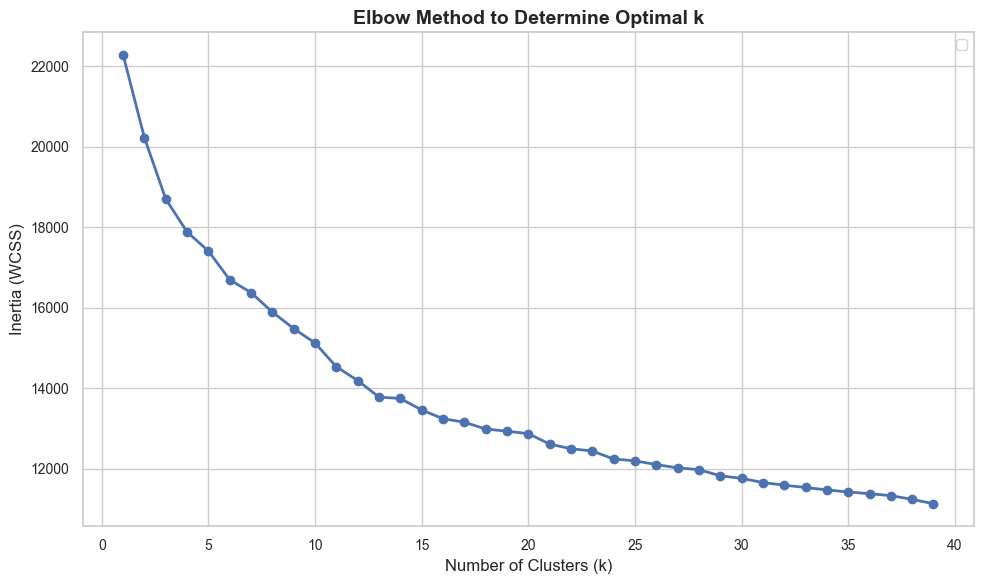

In [4]:
# Apply seaborn theme
sns.set_theme(style="whitegrid")

# Elbow curve with Seaborn aesthetic
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', markersize=6, linewidth=2, color=sns.color_palette("deep")[0])

plt.title('Elbow Method to Determine Optimal k', fontsize=14, weight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

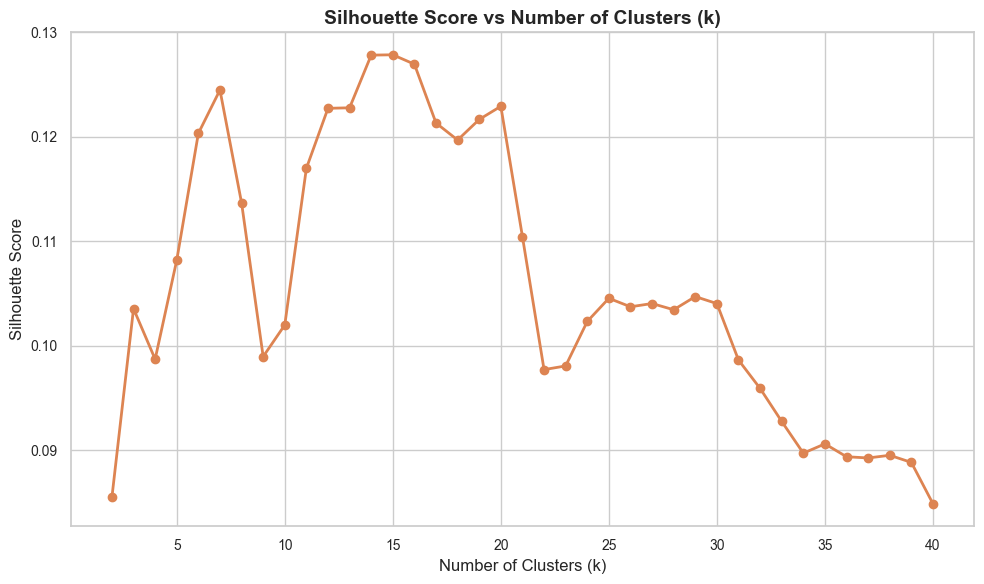

In [5]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

K_range = range(2, 41)
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', markersize=6, linewidth=2, color=sns.color_palette("deep")[1])

plt.title('Silhouette Score vs Number of Clusters (k)', fontsize=14, weight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


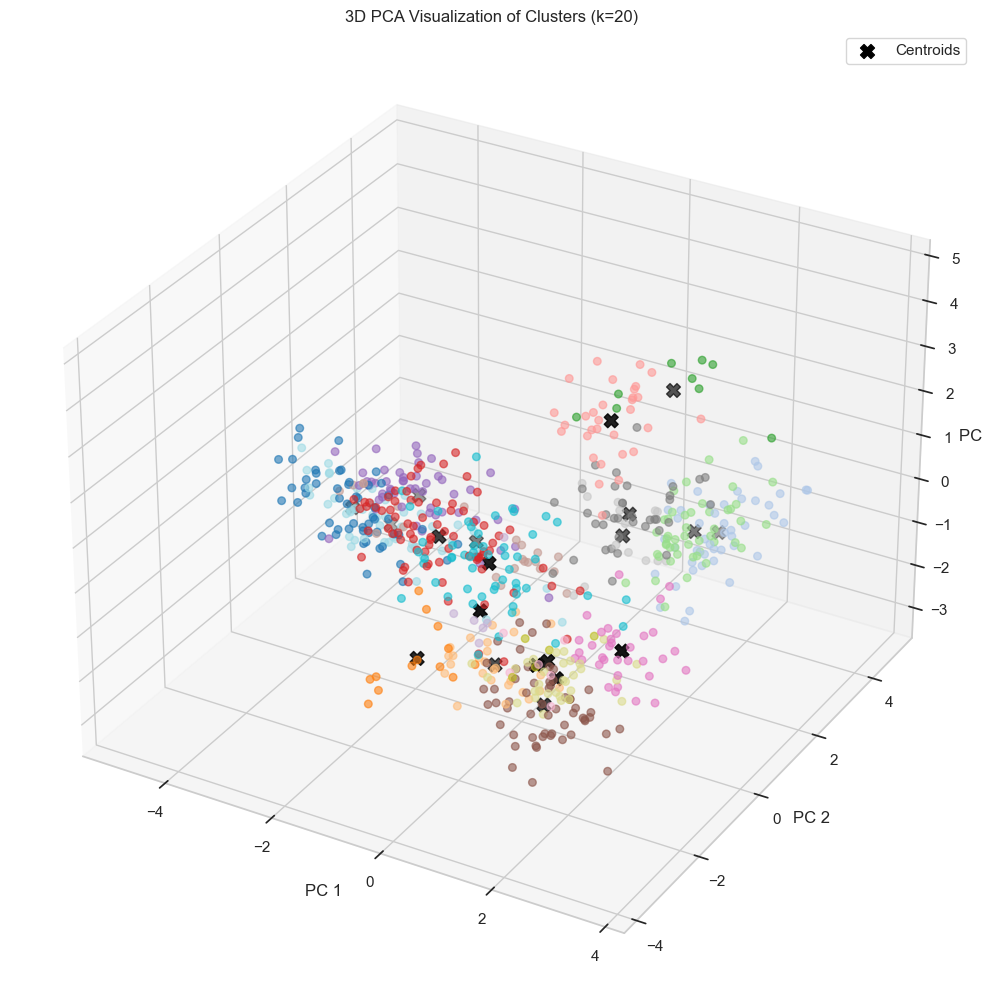

In [6]:
# KMeans clustering
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# PCA to reduce to 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
centroids_pca = pca.transform(centroids)

# 3D plot
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='tab20', s=30, alpha=0.6)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2], c='black', s=100, marker='X', label='Centroids')

ax.set_title(f'3D PCA Visualization of Clusters (k={k})')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
def print_summaries_in_cluster(cluster_num, X_norm, labels, centroids, df, top_n=10):
    # Get indices of points in the cluster
    indices = np.where(labels == cluster_num)[0]
    
    # Compute distances to centroid
    dists = np.linalg.norm(X_norm[indices] - centroids[cluster_num], axis=1)
    
    # Get top_n closest
    top_idxs = indices[np.argsort(dists)[:top_n]]
    top_dists = np.sort(dists)[:top_n]
    
    print(f"Cluster {cluster_num} – Top {top_n} closest summaries to centroid:\n")
    for rank, (i, dist) in enumerate(zip(top_idxs, top_dists), 1):
        print(f"{rank}. Index {i} | Distance: {dist:.4f}")
        print(df.loc[i, 'Session_Summary'][:250] + "...\n")
print_summaries_in_cluster(9, X_norm=X, labels=kmeans.labels_, centroids=kmeans.cluster_centers_, df=df)


Cluster 9 – Top 10 closest summaries to centroid:

1. Index 542 | Distance: 2.3961
we analyzed different types of roc curves today. an roc curve charts the true positive rate against the false positive rate for classifying instances at different threshold levels. we established that a curve that is flat signifies that the classifie...

2. Index 440 | Distance: 2.4758
we studied different types of roc curves today, which depict the relationship between true positives and false positives at various thresholds. the classifier's performance deteriorated the more the curve is flat. a flat roc curve indicates that the ...

3. Index 320 | Distance: 2.4824
roc curves, which depict true positives against false positives at different threshold values, were the subject of our exploration today. we discovered that the classifier's performance decreased with a flatter curve. while the false positive rate co...

4. Index 459 | Distance: 2.5691
today we looked at different types of roc curves.roc cur

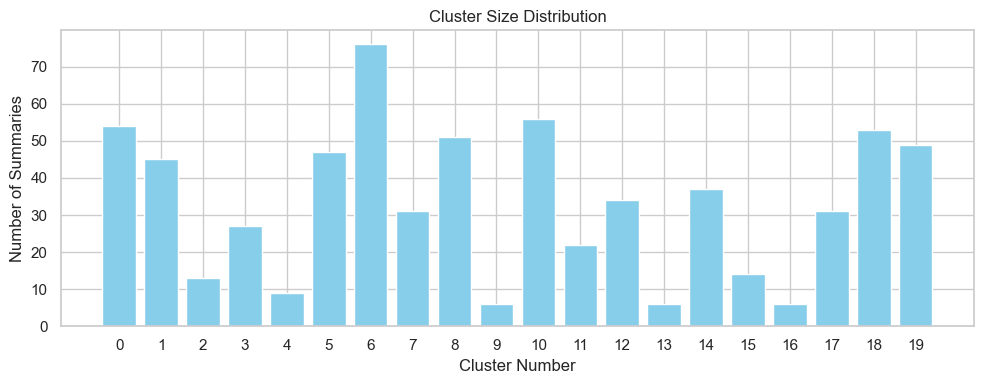

In [8]:


cluster_counts = Counter(kmeans.labels_)
sorted_counts = sorted(cluster_counts.items())

clusters, counts = zip(*sorted_counts)

plt.figure(figsize=(10, 4))
plt.bar(clusters, counts, color='skyblue')
plt.xlabel("Cluster Number")
plt.ylabel("Number of Summaries")
plt.title("Cluster Size Distribution")
plt.xticks(range(len(clusters)))
plt.tight_layout()
plt.show()

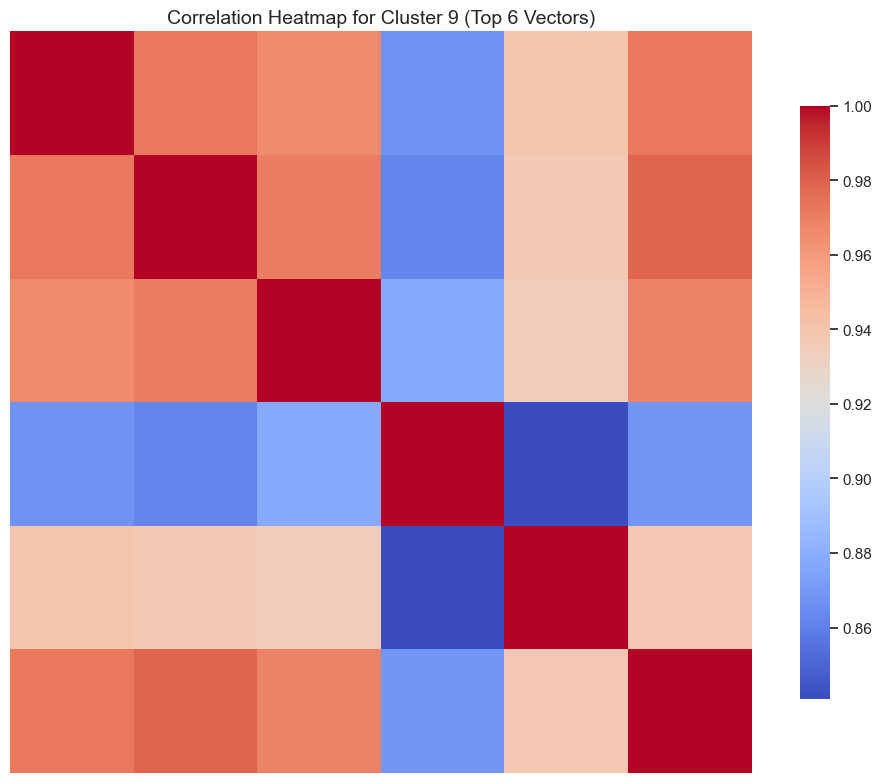

In [9]:
def plot_cluster_correlation_heatmap(cluster_num, X_norm, labels, df, max_vectors=50):
    indices = np.where(labels == cluster_num)[0]
    
    if len(indices) == 0:
        print(f"No items found in cluster {cluster_num}")
        return

    # Limit number of vectors for visualization
    selected_indices = indices[:max_vectors]
    vectors = X_norm[selected_indices]
    
    # Compute correlation matrix
    corr_matrix = np.corrcoef(vectors)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', square=True, 
                xticklabels=False, yticklabels=False, cbar_kws={"shrink": 0.8})
    plt.title(f'Correlation Heatmap for Cluster {cluster_num} (Top {len(selected_indices)} Vectors)', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_cluster_correlation_heatmap(cluster_num=9, X_norm=X, labels=kmeans.labels_, df=df)


## Exporting files

In [10]:
# Inputs
cluster_counts = [15, 20, 25, 30]  # Modify as needed
X = X  # Your embedding vectors (as numpy array or list of lists)
summaries = df['Session_Summary']  # Your text

for k in cluster_counts:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    # ----- Summary + Cluster CSV -----
    df_out = pd.DataFrame({
        'Summary': summaries,
        'Embedding': [','.join(map(str, vec)) for vec in X],
        'Cluster_Label': labels
    })
    df_out.to_csv(f'clustered_summaries_k{k}.csv', index=False)

    # ----- Cluster Centroids CSV -----
    df_centroids = pd.DataFrame({
        'Cluster_ID': list(range(k)),
        'Centroid_Vector': [','.join(map(str, vec)) for vec in kmeans.cluster_centers_]
    })
    df_centroids.to_csv(f'cluster_centroids_k{k}.csv', index=False)

    # ----- Clustered Summaries JSON -----
    cluster_json = {}
    for summary, label in zip(summaries, labels):
        cluster_json.setdefault(int(label), []).append(summary)

    with open(f'clustered_summaries_k{k}.json', 'w', encoding='utf-8') as f:
        json.dump(cluster_json, f, indent=2, ensure_ascii=False)
